# Assignment I - The Aiyagari Model

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Q2: Calibrate steady state](#toc2_)    
- 3. [Q3: Partial equilibrium effects of tax changes](#toc3_)    
- 4. [Q4: Tax reform](#toc4_)    
- 5. [Q5: Transition path](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCModel import HANCModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANCModelClass(name='baseline') # create an instance of the model
model.setup() # setup

## 2. <a id='toc2_'></a>[Q2: Calibrate steady state](#toc0_)

In [3]:
model = HANCModelClass(name='baseline') # create an instance of the model
model.setup() # setup

# Guess
beta = 0.95
transfer = 0.1
K = 6.
phi = .5

x0 = np.array([beta, transfer, K, phi])
model.find_ss(calibrate=True, do_print=True, x0=x0) # find the steady state

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Implied K =  5.154
Implied Y =  1.718
Implied K/Y =  3.000
Discrepancy in A =  -0.00000000
Discrepancy in L =  -0.00000000
Discrepancy in Y =   0.00000000
Discrepancy in G =   0.00000000
found steady state in 6.8 secs


#### Show aggregate quantities and prices:

In [4]:
ss = model.ss
for varname in model.varlist:
        print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

Gamma          : 1.0000
K              : 5.1537
L              : 1.0000
rK             : 0.1100
w              : 1.1510
Y              : 1.7179
A              : 5.1537
r              : 0.0500
transfer       : 0.3711
tau_l          : 0.3000
tau_a          : 0.1000
A_hh           : 5.1537
C_hh           : 1.4087
ELL_hh         : 1.0570
L_hh           : 1.0000
TAXES_hh       : 0.3711
I              : 0.3092
clearing_A     : -0.0000
clearing_L     : -0.0000
clearing_Y     : 0.0000
clearing_G     : 0.0000


#### Show a measure of wealth inequality, and discuss briefly what determines wealth inequality in the model.


In [5]:

z_grid = model.par.z_grid
a_grid = model.par.a_grid

# Summing the 1 i_fix type and the 5 z types in the final distribution to collapse the (1x5x300) array to a (300) array
a_dist = model.ss.D.sum(axis=(0,1)) 
a_abs = a_dist * a_grid
a_total = a_abs.sum()

a_share = a_abs / a_total

#add 0 to the beginning of the array to make the plot start at (0,0)
a_share = np.hstack((0, a_share.cumsum()))
pop_share = np.hstack((0, a_dist.cumsum()))

plt.plot(pop_share, a_share, label='Lorentz curve')
plt.plot(pop_share, pop_share, label='45 degree line') 
plt.title('Lorentz curve')
plt.xlabel('Share of households')
plt.ylabel('Share of total wealth');

def gini(share, wealth):
    n = len(share)
    G = 0
    for i in range(n):
        for j in range(n):
            G += share[i] * share[j] * abs(wealth[i] - wealth[j])
    mu = share @ wealth
    return G / (2 * mu)
G = gini(model.ss.D.sum(axis=(0,1)), a_grid)

print(f'Gini coefficient: {G:.4f}')

Gini coefficient: 0.6986


## 3. <a id='toc3_'></a>[Q3: Partial equilibrium effects of tax changes](#toc0_)

In [6]:
taxrates = [0.1, 0.25, 0.5, 0.75, 0.9, .95, .99]
Ls_a = []
As_a = []
Cs_a = []

for tau_a in taxrates:
    _ = model.copy()
    _.ss.tau_a = tau_a
    _.solve_hh_ss()
    _.simulate_hh_ss()

    Ls_a.append(_.ss.L_hh) 
    As_a.append(_.ss.A_hh)
    Cs_a.append(_.ss.C_hh)

Ls_l = []
As_l = []
Cs_l = []

for tau_l in taxrates:
    _ = model.copy()
    _.ss.tau_l = tau_l
    _.solve_hh_ss()
    _.simulate_hh_ss()

    Ls_l.append(_.ss.L_hh) 
    As_l.append(_.ss.A_hh)
    Cs_l.append(_.ss.C_hh)

In [7]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(taxrates, Ls_a, marker='o', label='Labor')
ax.plot(taxrates, As_a, marker='o', label='Assets')
ax.plot(taxrates, Cs_a, marker='o', label='Consumption')
ax.set_xlabel('$\\tau^{a}$')
ax.set_ylabel('Aggregate value')
ax.legend();

ax = fig.add_subplot(1,2,2)
ax.plot(taxrates, Ls_l, marker='o', label='Labor')
ax.plot(taxrates, As_l, marker='o', label='Assets')
ax.plot(taxrates, Cs_l, marker='o', label='Consumption')
ax.set_xlabel('$\\tau^{\ell}$')
ax.set_ylabel('Aggregate value')
ax.legend();

## 4. <a id='toc4_'></a>[Q4: Tax reform](#toc0_)

Raise capital tax from 10% to 50%

In [8]:
model_high_tax = model.copy()
model_high_tax.par.tau_a_ss = 0.5 

Find new steady state 

In [9]:
x0 = [model.ss.transfer, 
      model.ss.K, 
      model.ss.L]
model_high_tax.find_ss(do_print=True, calibrate=False, x0=x0)

Implied K =  3.472
Implied Y =  1.516
Implied K/Y =  2.291
Discrepancy in A =  -0.00000000
Discrepancy in L =   0.00000000
Discrepancy in Y =   0.00000000
Discrepancy in G =   0.00000000
found steady state in 2.9 secs


Analysis 

In [10]:
print(f'Old Y_ss: {model.ss.Y:.4f} \nNew Y_ss: {model_high_tax.ss.Y:.4f}')

Old Y_ss: 1.7179 
New Y_ss: 1.5155


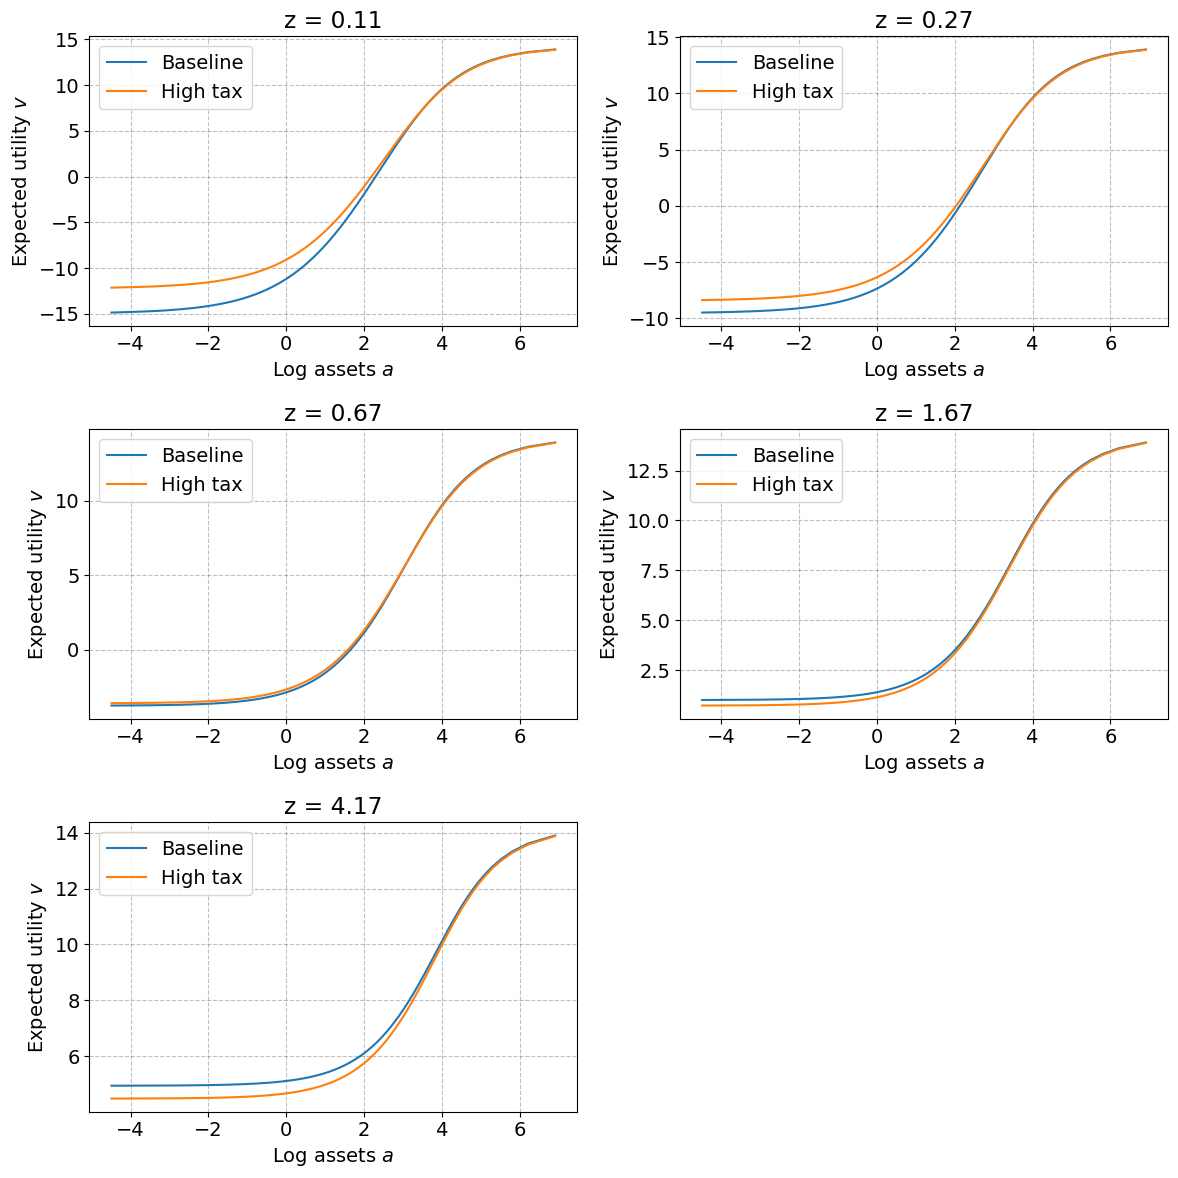

In [11]:
fig = plt.figure(figsize=(12,12))

for z in range(5):
    ax = fig.add_subplot(3, 2, z+1)
    ax.set_title(f'z = {z_grid[z]:.2f}')
    ax.plot(
            np.log(a_grid[1:]), 
            model.ss.v[0,z,:][1:], 
            label=f'Baseline');
    ax.plot(
            np.log(a_grid[1:]), 
            model_high_tax.ss.v[0,z,:][1:], 
            label=f'High tax');
    ax.set_xlabel('Log assets $a$')
    ax.set_ylabel('Expected utility $v$')
    ax.legend()

plt.tight_layout()

## 5. <a id='toc5_'></a>[Q5: Transition path](#toc0_)

Ensure that transition path blocks are consistent with steady states 

In [12]:
model_high_tax.info(only_blocks=True)

production_firm: [Gamma,K,L] -> [rK,w,Y]
mutual_fund: [K,rK] -> [A,r]
transfers: [] -> [transfer]
hh: [r,tau_a,tau_l,transfer,w] -> [A_hh,C_hh,ELL_hh,L_hh,TAXES_hh]
market_clearing: [A,A_hh,L,L_hh,K,Y,C_hh,TAXES_hh,transfer] -> [I,clearing_A,clearing_L,clearing_Y,clearing_G]


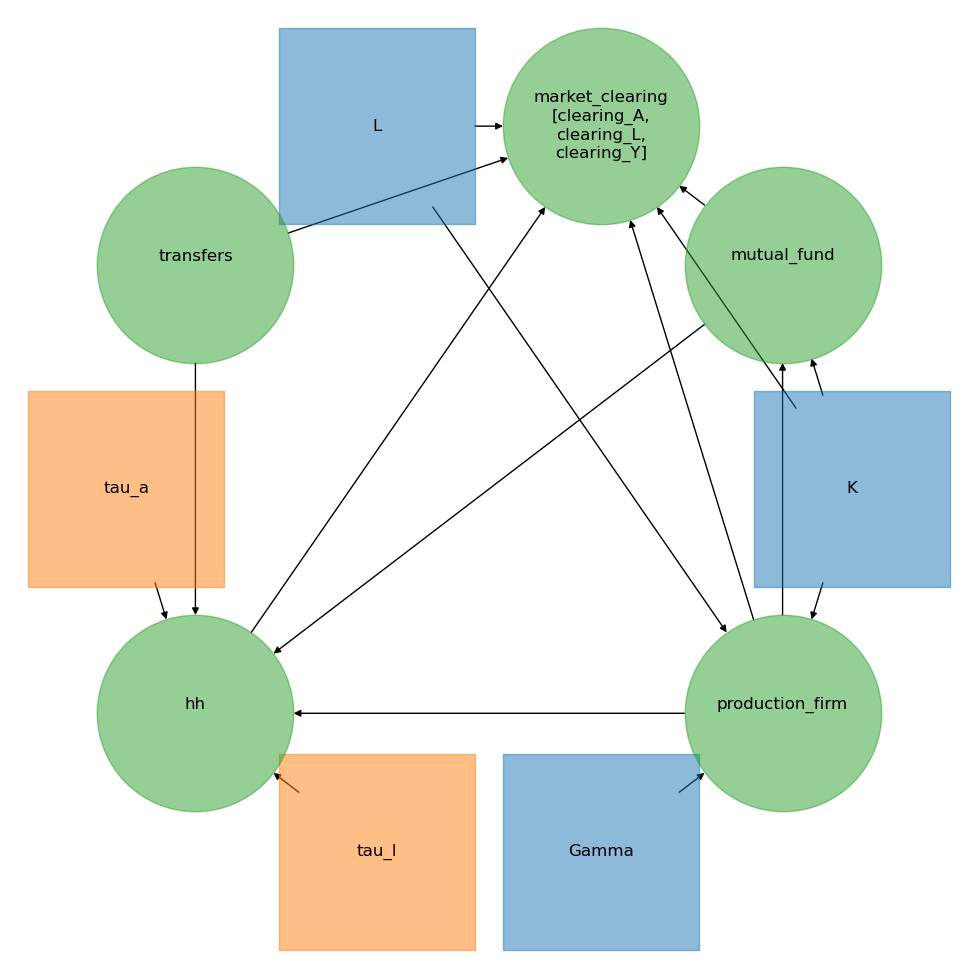

In [13]:
model_high_tax.draw_DAG()

In [14]:
model_high_tax.test_path()

shocks: tau_a tau_l 
unknowns: Gamma K L 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production_firm
  rK               0.0e+00
  w                0.0e+00
  Y                0.0e+00
 blocks.mutual_fund
  A                9.1e-11
  r                0.0e+00
 blocks.transfers
  transfer         0.0e+00
 hh
  A_hh             1.6e-08
  C_hh             1.1e-09
  ELL_hh           1.4e-09
  L_hh             1.0e-09
  TAXES_hh         4.2e-10
 blocks.market_clearing
  I                8.3e-17
  clearing_A       1.6e-08 [target]
  clearing_L       1.0e-09 [target]
  clearing_Y       1.2e-09 [target]
  clearing_G       4.2e-10


In [15]:
model_high_tax.compute_jacs()

In [16]:
# In the first period, the tax rate is reduced by 0.4 to 0.1. 
# From the second period onwards, the tax rate is kept constant at 0.5.
dtau_a = np.zeros_like(np.arange(model_high_tax.par.T), dtype=float)
dtau_a[0] = -.4 
model_high_tax.find_transition_path({'dtau_a':dtau_a})

Transition

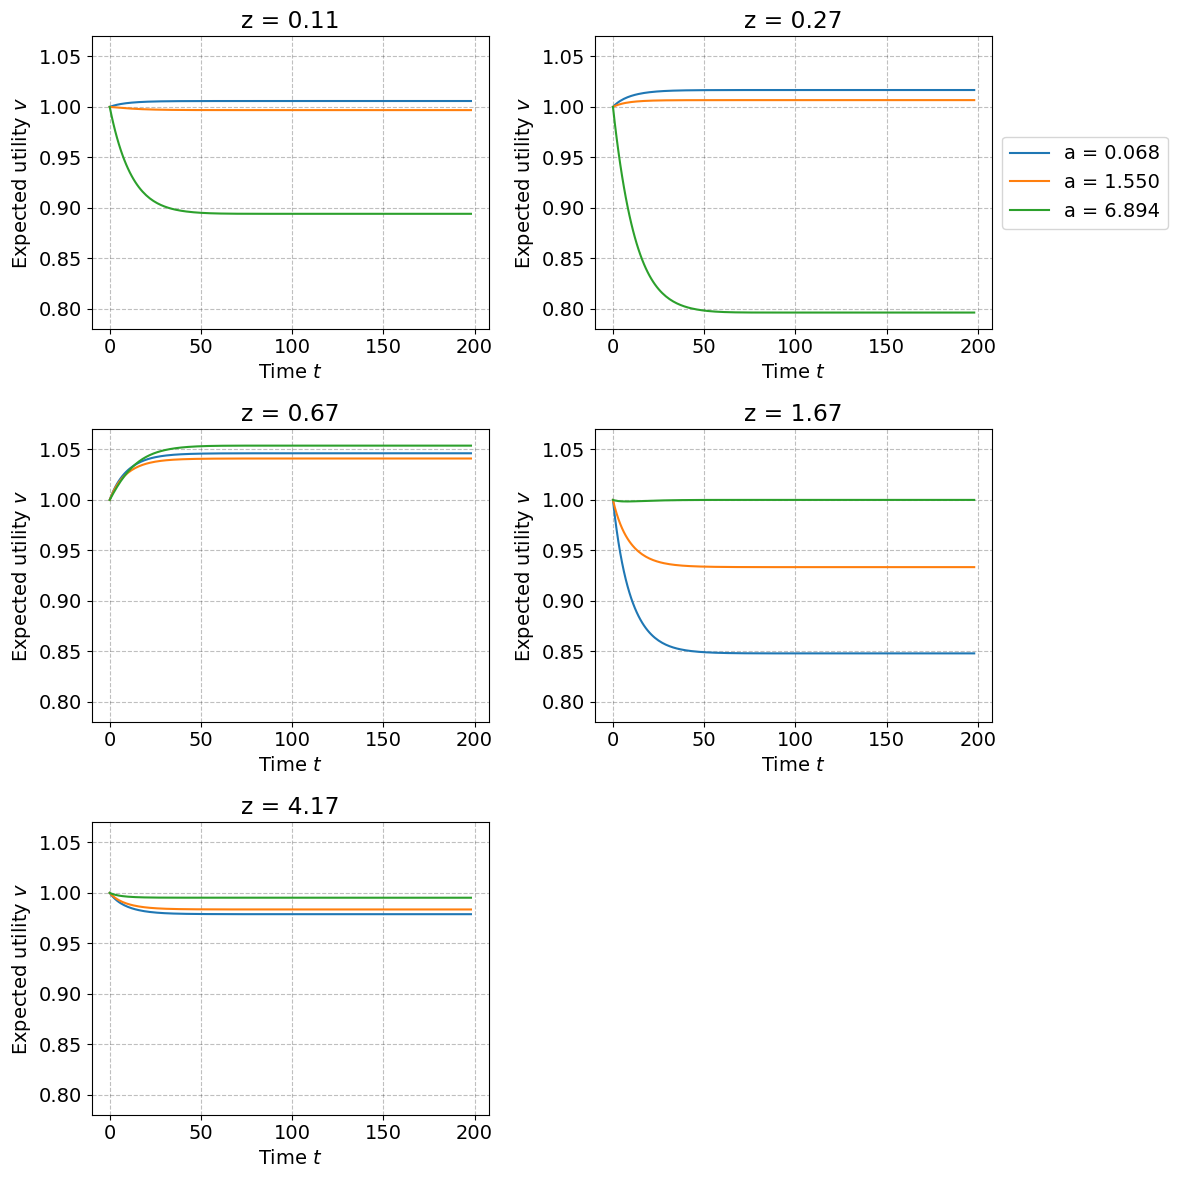

In [17]:
# Get asset quantiles
a_dist = model.ss.D.sum(axis=(0,1))
i_p25 = np.argmin(np.abs((a_dist.cumsum() - .25)))
i_p50 = np.argmin(np.abs((a_dist.cumsum() - .50)))
i_p75 = np.argmin(np.abs((a_dist.cumsum() - .75)))
a_quantiles = [i_p25, i_p50, i_p75]

fig = plt.figure(figsize=(12,12))

for i_z, z in enumerate(z_grid):
    
    ax = fig.add_subplot(3, 2, 1+i_z)
    ax.set_title(f'z = {z:.2f}')

    for i, i_a in enumerate(a_quantiles):
        v = model_high_tax.path.v[1:, 0, i_z, i_a] #(t, i_fix, i_z, i_a)
        v_rel = v / model_high_tax.path.v[1,  0, i_z, i_a] # Normalize to initial levels
    
        ax.plot(v_rel, label=f'a = {a_grid[i_a]:.3f}');
        
        ax.set_ylim(.78, 1.07)
        ax.set_xlabel('Time $t$')
        ax.set_ylabel('Expected utility $v$')
        if i_z ==1:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()